In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import re
import itertools
from numpy import *
from pandas.core.frame import DataFrame 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_selection
from mrmr import mrmr_classif
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,matthews_corrcoef,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import MultipleLocator


In [2]:
def performance(y_predict,y_test):
   #定义RMSE,NRMSE,R2,Pearson,Spearman
   y_predict=y_predict.flatten()
   SS_R=sum((y_test-y_predict)**2)
   SS_T=sum((y_test-np.mean(y_test))**2)
   R2=1-(float(SS_R))/SS_T
   R2=r2_score(y_test,y_predict)
   rmse=np.sqrt(mean_squared_error(y_test, y_predict))
   nrmse=rmse/np.std(y_test)
   pear=pearsonr(y_test, y_predict)[0]
   spear=spearmanr(y_test,y_predict)[0]
   data=[R2,rmse,nrmse,pear,spear]
   return data

def plsmodel(x_train,y_train,x_test,y_test,component):
    ##training set 建立模型
    pls_model_set=PLSRegression(n_components=component)###scale=True默认标准化数据
    pls_model=pls_model_set.fit(x_train,y_train)
    y_predict=pls_model.predict(x_train)
    train_outdata=performance(y_predict,y_train)
    ###testing数据集
    y_test_predict=pls_model.predict(x_test)
    test_outdata=performance(y_test_predict,y_test)
    ###合并training和testing结果
    outdata=train_outdata+test_outdata
    return outdata 

def cross_output(all_x,y,component):
    i=0
    outdata=pd.DataFrame(columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for train_idx, test_idx in kf.split(all_x):
        X_train = preprocessing.scale(all_x.iloc[train_idx])
        X_test = preprocessing.scale(all_x.iloc[test_idx])
        y_train =y[train_idx]
        y_test = y[test_idx]
        outdata.loc[i]=plsmodel(X_train,y_train,X_test,y_test,component)
        i +=1
    out=np.array(outdata.mean(axis=0))
    return out




In [16]:
def predict_model(reg,x_train,y_train,x_test,y_test):
    y_predict=reg.predict(x_train)
    train_outdata=performance(y_predict,y_train)
    y_test_predict=reg.predict(x_test)
    test_outdata=performance(y_test_predict,y_test)
    ###合并training和testing结果
    outdata=train_outdata+test_outdata
    test_predict=y_test_predict.flatten()
    return outdata,test_predict

In [8]:
def predict(all_x,y,component):
    i=0
    outdata=pd.DataFrame(columns=('test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    Y_predict,Y_measured=[],[]
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for train_idx, test_idx in kf.split(all_x):
        X_train = preprocessing.scale(all_x.iloc[train_idx])
        X_test = preprocessing.scale(all_x.iloc[test_idx])
        y_train =y[train_idx]
        y_test = y[test_idx]
        pls_model_set=PLSRegression(n_components=component).fit(X_train,y_train)###scale=True默认标准化数据
        y_predict=pls_model_set.predict(X_test)

        outdata.loc[i]=performance(y_predict,y_test)
        Y_predict.extend(list(y_predict.flatten()))
        Y_measured.extend(list(y_test))
        i=i+1
    out=np.array(outdata.mean(axis=0))
    return Y_predict,Y_measured,out

def cross_output(all_x,y,component):
    i=0
    outdata=pd.DataFrame(columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for train_idx, test_idx in kf.split(all_x):
        X_train = preprocessing.scale(all_x.iloc[train_idx])
        X_test = preprocessing.scale(all_x.iloc[test_idx])
        y_train =y[train_idx]
        y_test = y[test_idx]
        outdata.loc[i]=plsmodel(X_train,y_train,X_test,y_test,component)
        i +=1
    out=np.array(outdata.mean(axis=0))
    return out

In [3]:
all_feature=pd.read_csv('/home/lynn/pls/code/data/all_x_matrix.csv')
all_x=all_feature.iloc[:,1:] ## x变量
y=all_feature.iloc[:,0]         #y变量

**<font size=5 color = red> 文章中的特征子集，用基于不同的component的PLSR模型。component=1时，预测结果较好。</font>**

In [4]:

#提取123个feature  文章中的123个feature
def out123(all_x,y):
    feature123=pd.read_csv("/home/lynn/pls/code/data/features.csv")
    feature123=list(feature123['Feature name'])
    x_123=all_x[feature123]
    
    out123=[]
    for i in range(1,11):
        out123.append(cross_output(x_123,y,i))
    out123=pd.DataFrame(out123,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    return out123
out123_1=out123(all_x,y)
outpath="/home/lynn/pls/result"
out123_1.to_csv(os.path.join(outpath,"out_123features_exiting feature subset.csv"))
out123_1

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.660619,0.267015,0.582442,0.812738,0.775944,0.408352,0.339677,0.761814,0.705181,0.645098
1,0.812407,0.198362,0.432672,0.901289,0.843898,0.399189,0.337291,0.762748,0.726541,0.601471
2,0.896608,0.147313,0.321117,0.946877,0.924075,0.354090,0.354718,0.796917,0.713693,0.579412
3,0.930885,0.120468,0.262601,0.964818,0.949727,0.313975,0.363834,0.821158,0.711083,0.600980
4,0.955181,0.096914,0.211201,0.977329,0.966210,0.292943,0.369443,0.834163,0.711802,0.616667
5,0.968203,0.081628,0.177942,0.983971,0.976646,0.236724,0.383352,0.866349,0.699819,0.585294
6,0.978026,0.067823,0.147911,0.988951,0.984380,0.184933,0.395407,0.894174,0.686507,0.589216
7,0.982868,0.059852,0.130529,0.991396,0.988075,0.161781,0.400661,0.905186,0.677058,0.589216
8,0.987280,0.051496,0.112357,0.993619,0.990991,0.103987,0.410694,0.931129,0.670535,0.601471
9,0.990332,0.044698,0.097585,0.995153,0.992930,0.076275,0.415163,0.942211,0.666927,0.592157


In [13]:
feature123=pd.read_csv("/home/lynn/pls/code/data/features.csv")
feature123=list(feature123['Feature name'])
x_123=all_x[feature123]
y_predict123,y_measured123,performance123=predict(x_123,y,1)
performance123

array([0.40835214, 0.33967742, 0.76181447, 0.70518094, 0.64509804])

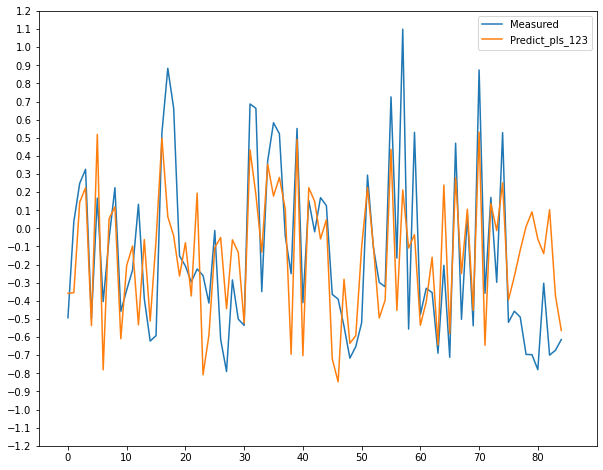

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(y_measured123,label='Measured')
plt.plot(y_predict123,label='Predict_pls_123')
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
l=[-5,90,-1.2,1.2]
plt.axis(l)
plt.xticks(list(range(0,90,10)))
plt.legend(loc='best')
plt.show()



No handles with labels found to put in legend.


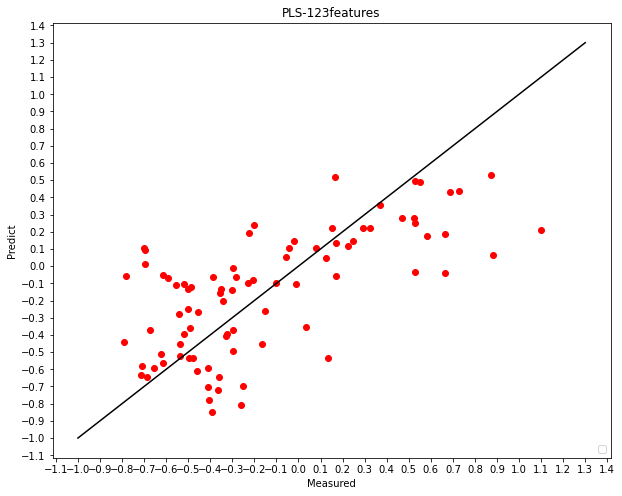

In [15]:
plt.figure(figsize=(10, 8))
x_pre=np.linspace(-1,1.3,100)
y_pre=np.linspace(-1,1.3,100)
plt.scatter(y_measured123,y_predict123,color='red')
plt.plot(x_pre,y_pre,color='black')
x_major_locator=MultipleLocator(0.1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
l=[-1.2,1.2,-1.2,1.2]
plt.legend(loc='lower right')
plt.xlabel('Measured')
plt.ylabel('Predict')
plt.title('PLS-123features')
plt.show()

**<font size=5 color = red> 使用全部feature 做训练，其中component=3时，取得最好的结果。700个feature中有420个sequence，184个physicochemical，196个structual</font>**

In [5]:
out700=[]
for i in range(1,11):
    out700.append(cross_output(all_x,y,i))
out700=pd.DataFrame(out700,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
out700

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.678018,0.260001,0.567219,0.823346,0.799672,0.348659,0.352908,0.796828,0.673275,0.646569
1,0.878129,0.159974,0.348898,0.937075,0.937565,0.447454,0.328617,0.740145,0.757084,0.681863
2,0.943162,0.109034,0.237824,0.971157,0.975112,0.472350,0.322564,0.721843,0.766566,0.686275
3,0.980309,0.063913,0.139132,0.990102,0.984876,0.460920,0.326378,0.730950,0.761281,0.680392
4,0.991088,0.042997,0.093678,0.995533,0.992640,0.429491,0.335446,0.752465,0.745140,0.676961
5,0.996040,0.028788,0.062712,0.998018,0.995152,0.413597,0.339488,0.762372,0.737391,0.658824
6,0.997971,0.020620,0.044852,0.998985,0.997023,0.413192,0.340106,0.762787,0.735167,0.660294
7,0.998880,0.015176,0.032948,0.999440,0.998046,0.413256,0.339928,0.762623,0.735935,0.660294
8,0.999304,0.011895,0.025827,0.999652,0.998496,0.413377,0.340048,0.762476,0.734921,0.659314
9,0.999570,0.009316,0.020231,0.999785,0.998985,0.412757,0.340264,0.762760,0.734207,0.659314


**<font size=5 color = red> 去除全部是0的feature，剩余647个feature，但是结果与700个feature的相同，所以下面的工作使用647个feature，647个feature形成原始特征集</font>**

In [5]:
##除去全是0的feature 剩余647个feature
mask=(all_x==0).all(0)
col_index=np.where(mask)[0]
aa=np.array(range(0,700))
aa1=np.delete(aa,col_index)
x_647=all_x[all_x.columns[aa1]]
#
out647=[]
for i in range(1,11):
    out647.append(cross_output(x_647,y,i))
out647=pd.DataFrame(out647,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
outpath="/home/lynn/pls/result"
out647.to_csv(os.path.join(outpath,"out_647features_component.csv"))
out647

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.678018,0.260001,0.567219,0.823346,0.799672,0.348659,0.352908,0.796828,0.673275,0.646569
1,0.878129,0.159974,0.348898,0.937075,0.937565,0.447454,0.328617,0.740145,0.757084,0.681863
2,0.943162,0.109034,0.237824,0.971157,0.975112,0.472350,0.322564,0.721843,0.766566,0.686275
3,0.980309,0.063913,0.139132,0.990102,0.984876,0.460920,0.326378,0.730950,0.761281,0.680392
4,0.991088,0.042997,0.093678,0.995533,0.992640,0.429491,0.335446,0.752465,0.745140,0.676961
5,0.996040,0.028788,0.062712,0.998018,0.995152,0.413597,0.339488,0.762372,0.737391,0.658824
6,0.997971,0.020620,0.044852,0.998985,0.997023,0.413192,0.340106,0.762787,0.735167,0.660294
7,0.998880,0.015176,0.032948,0.999440,0.998046,0.413256,0.339928,0.762623,0.735935,0.660294
8,0.999304,0.011895,0.025827,0.999652,0.998496,0.413377,0.340048,0.762476,0.734921,0.659314
9,0.999570,0.009316,0.020231,0.999785,0.998985,0.412757,0.340264,0.762760,0.734207,0.659314


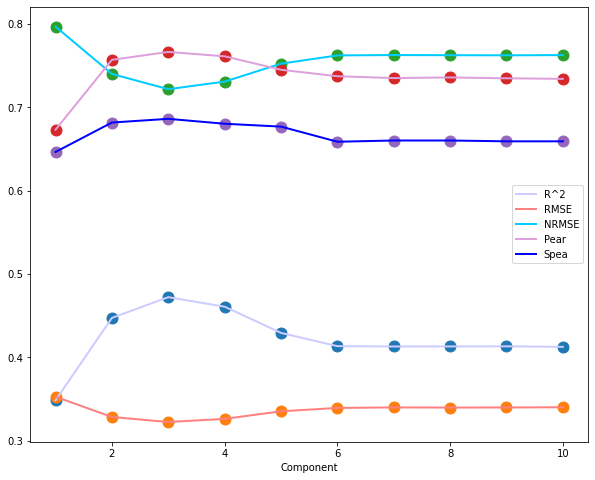

In [13]:
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
lab=['R^2','RMSE','NRMSE','Pear','Spea']
x=list(range(1,11))
for i in ['test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea']:
    plt.plot(x,out647[i],color=col[d],lw=2, label= lab[d])
    plt.scatter(x, out647[i], marker='o', s=120)
    plt.legend(loc="best")
    d+=1
plt.xlim=([1,10])
plt.xlabel('Component')
fig.show()

**<font size=5 color = red> 对647个feature，做mRMR 和forward feature researching method 的feature selection，其中使用mRMR method 使用MID标准</font>**

In [6]:
mid=list(pd.read_csv("/home/lynn/pls/code/data/mid-miq.csv")['mid'])
miq=list(pd.read_csv("/home/lynn/pls/code/data/mid-miq.csv")['miq'])
miq[634]='NA'
mid[620]='NA'

In [39]:
out_mrmr_mid=[]
for i in range(3,648):
    x_mrmr_mid=x_647[mid[0:i]]
    out_mrmr_mid.append(cross_output(x_mrmr_mid,y,3))
out_mrmr_mid=pd.DataFrame(out_mrmr_mid,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
outpath="/home/lynn/pls/result"
out_mrmr_mid.to_csv(os.path.join(outpath,"pls_85sample_647feature_mrmr-mid-order.csv"))

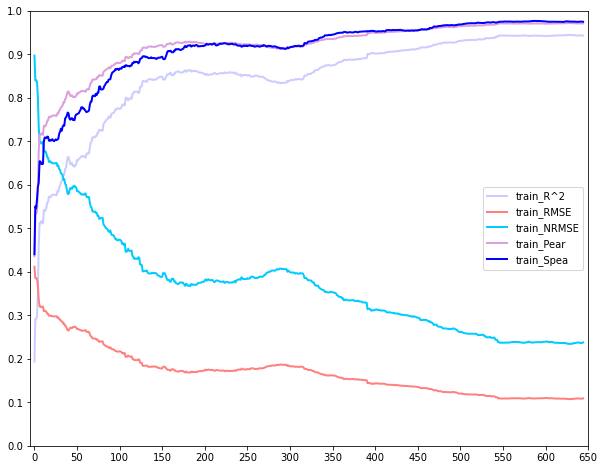

In [6]:
out_mrmr_mid=pd.read_csv('/home/lynn/pls/result/pls_85sample_647feature_mrmr-mid-order.csv')
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
for i in ['train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea']:
    plt.plot(out_mrmr_mid[i],color=col[d],lw=2, label= '{}'.format(i))
    plt.legend(loc="best")
    d+=1
plt.xlim=([3,647])
x_major_locator=MultipleLocator(50)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlim=([-5,650])
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim=([0,1])
l=[-5,650,0,1]
plt.axis(l)
fig.show()

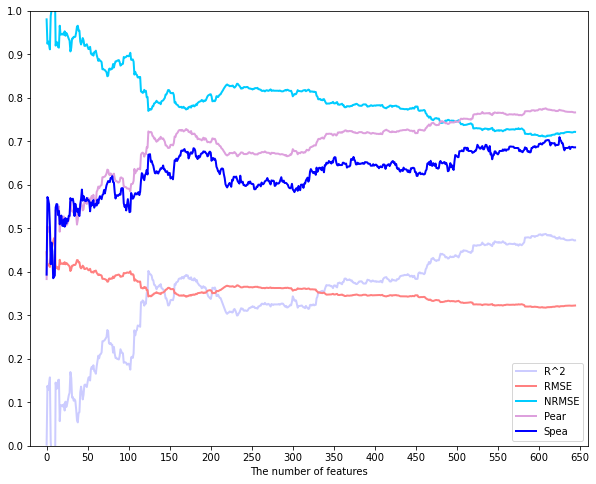

In [56]:
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
lab=['R^2','RMSE','NRMSE','Pear','Spea']
for i in ['test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea']:
    plt.plot(out_mrmr_mid[i],color=col[d],lw=2, label=lab[d])
    plt.legend(loc="lower right")
    d+=1
plt.xlim=([3,647])
x_major_locator=MultipleLocator(50)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlim=([-5,650])
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim=([0,1])
l=[-20,660,0,1]
plt.axis(l)
plt.xlabel('The number of features')
fig.show()

**<font size=5 color = red> mRMR features 中当第625个feature添加到特征子集中参与训练模型的时候，取得最大的Spearman coefficient。</font>**

In [7]:
a=max(out_mrmr_mid['test_Spea'])
np.where(out_mrmr_mid['test_Spea']==a) ##625
a

0.7098039215686275

**<font size=5 color = red> mRMR method 使用MID 标准的结果，（可以忽略不看）</font>**

In [43]:
out_mrmr_miq=[]
for i in range(3,648):
    x_mrmr_miq=x_647[miq[0:i]]
    out_mrmr_miq.append(cross_output(x_mrmr_miq,y,3))
out_mrmr_miq=pd.DataFrame(out_mrmr_miq,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
outpath="/home/lynn/pls/result"
out_mrmr_miq.to_csv(os.path.join(outpath,"pls_85sample_647feature_mrmr-miq-order.csv"))

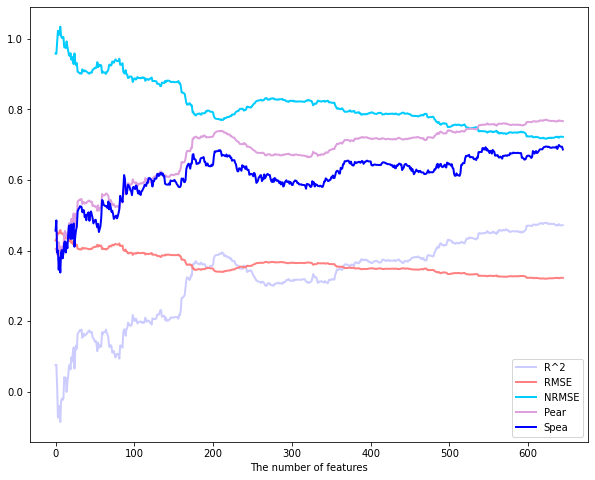

In [44]:
out_mrmr_miq=pd.read_csv('/home/lynn/pls/result/pls_85sample_647feature_mrmr-miq-order.csv')
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
lab=['R^2','RMSE','NRMSE','Pear','Spea']
for i in ['test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea']:
    plt.plot(out_mrmr_miq[i],color=col[d],lw=2, label=lab[d])
    plt.legend(loc="lower right")
    d+=1
plt.xlim=([3,647])
plt.xlabel('The number of features')
fig.show()

**<font size=5 color = red> 使用forward feature researching method ，component=3的PLSR 模型训练</font>**

In [9]:
feature_forward_cross=pd.read_csv("/home/lynn/pls/code/data/forward_feature_order_cross_component3.csv")
feature_forward=feature_forward_cross.iloc[:,1].values 
feature_forward[374]='NA'


In [14]:

#根据上面forward 得到的feature order 依次添加feature
out_forward_result=[]
for i in range(3,648):
    x_forward=x_647[feature_forward[0:i]]
    out_forward_result.append(cross_output(x_forward,y,3))
out_forward_result=pd.DataFrame(out_forward_result,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
outpath="/home/lynn/pls/result"
out_forward_result.to_csv(os.path.join(outpath,"pls_85sample_647feature_forward.csv"))
out_forward_result

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.345098,0.370762,0.807885,0.584412,0.704920,0.313752,0.369114,0.821197,0.642227,0.645588
1,0.381703,0.360165,0.784548,0.614576,0.694454,0.345250,0.359443,0.798020,0.650680,0.716176
2,0.408336,0.352417,0.767765,0.636734,0.711814,0.364240,0.352499,0.783741,0.665210,0.738235
3,0.456522,0.337737,0.735824,0.674020,0.745085,0.417609,0.336663,0.749768,0.698864,0.764216
4,0.511353,0.320327,0.698015,0.714195,0.777875,0.447874,0.328588,0.734435,0.721428,0.788235
...,...,...,...,...,...,...,...,...,...,...
640,0.940422,0.111635,0.243449,0.969744,0.975409,0.478987,0.321700,0.718423,0.770517,0.722549
641,0.940273,0.111780,0.243766,0.969667,0.975157,0.479268,0.321470,0.717979,0.770192,0.719608
642,0.940084,0.111949,0.244140,0.969569,0.974928,0.477583,0.321718,0.718849,0.769490,0.713725
643,0.940680,0.111366,0.242892,0.969876,0.975119,0.475409,0.321900,0.719962,0.769063,0.703922


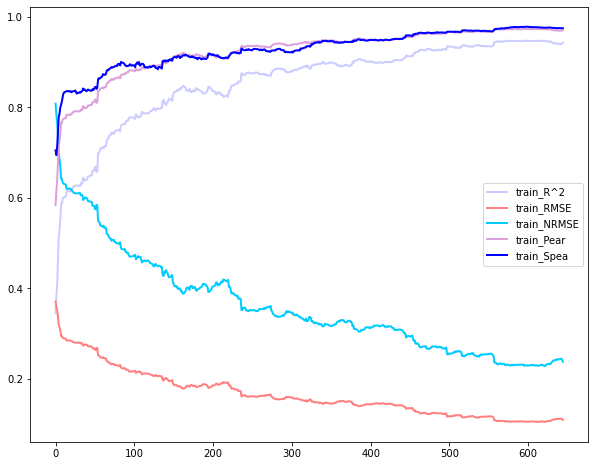

In [15]:
out_forward_result=pd.read_csv("/home/lynn/pls/result/pls_85sample_647feature_forward.csv")
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
for i in ['train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea']:
    plt.plot(out_forward_result[i],color=col[d],lw=2, label= '{}'.format(i))
    plt.legend(loc="best")
    d+=1
plt.xlim=([3,647])
fig.show()

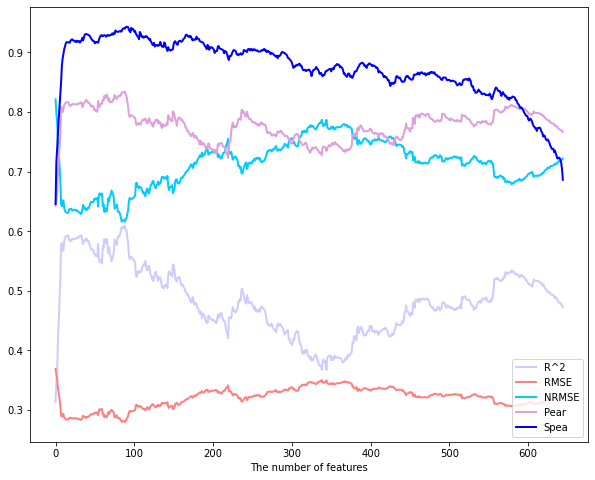

In [16]:
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
lab=['R^2','RMSE','NRMSE','Pear','Spea']
for i in ['test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea']:
    plt.plot(out_forward_result[i],color=col[d],lw=2, label=lab[d])
    plt.legend(loc="lower right")
    d+=1
plt.xlim=([3,647])
plt.xlabel('The number of features')
fig.show()

**<font size=5 color = red> 放大forward feature researching method 中第20 个 feature 到第110个feature 的曲线图</font>**

In [7]:
out_forward_result_50=[]
for i in range(20,110):
    x_forward_50=x_647[feature_forward[0:i]]
    out_forward_result_50.append(cross_output(x_forward_50,y,3))
out_forward_result_50=pd.DataFrame(out_forward_result_50,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
out_forward_result_50

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.614296,0.284720,0.620408,0.783430,0.835073,0.586262,0.285975,0.636093,0.812923,0.916667
1,0.613582,0.284987,0.620989,0.782977,0.836164,0.583830,0.286727,0.637476,0.810497,0.916176
2,0.615794,0.284154,0.619168,0.784370,0.835516,0.584932,0.286385,0.636618,0.811043,0.920098
3,0.616224,0.283992,0.618809,0.784638,0.833363,0.583573,0.287142,0.637868,0.810734,0.920588
4,0.620613,0.282336,0.615165,0.787389,0.835325,0.586734,0.286070,0.635336,0.813178,0.922059
...,...,...,...,...,...,...,...,...,...,...
85,0.784222,0.213016,0.464153,0.885509,0.895889,0.525239,0.308389,0.679971,0.781343,0.931373
86,0.781859,0.214189,0.466584,0.884157,0.896958,0.523392,0.309001,0.681335,0.778062,0.928922
87,0.779613,0.215299,0.469025,0.882892,0.899790,0.532047,0.306138,0.673944,0.780936,0.926961
88,0.777541,0.216297,0.471276,0.881725,0.896187,0.529708,0.306913,0.675361,0.779581,0.925490


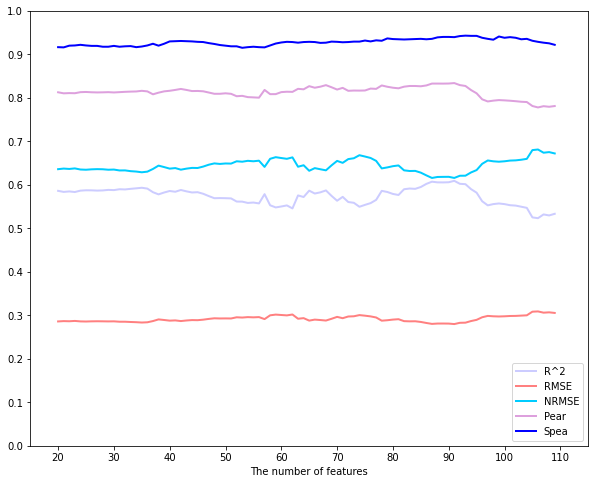

In [12]:
col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
d=0
x_50=range(20,110)
lab=['R^2','RMSE','NRMSE','Pear','Spea']
for i in ['test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea']:
    plt.plot(x_50,out_forward_result_50[i],color=col[d],lw=2, label=lab[d])
    plt.legend(loc="lower right")
    d+=1
x_major_locator=MultipleLocator(10)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlim=([20,110])
l=[15,115,0,1]
plt.axis(l)
plt.xlabel('The number of features')
fig.show()

**<font size=5 color = red> mRMR method 和forward feature researching method 的 Spearman coefficient 的对比图</font>**

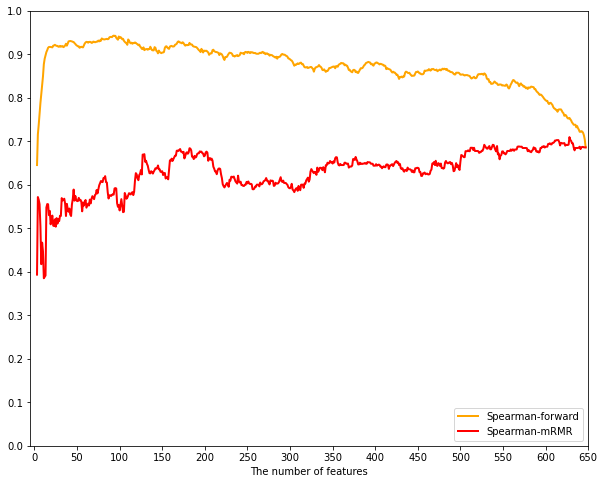

In [108]:


col=['#CCCCFF','#FF8080','#00CCFF','#DDA0DD','#0000FF']
fig=plt.figure(figsize=(10,8))
x_647=range(3,648)
plt.plot(x_647,out_forward_result['test_Spea'],color='orange',lw=2, label='Spearman-forward')
plt.plot(x_647,out_mrmr_mid['test_Spea'],color='red',lw=2, label='Spearman-mRMR')
plt.legend(loc="lower right")
x_major_locator=MultipleLocator(50)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
plt.xlim=([-5,650])
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim=([0,1])
l=[-5,650,0,1]
plt.axis(l)
plt.xlabel('The number of features')
fig.show()

**<font size=5 color = red> forward feature researching method 的最好的结果</font>**

In [5]:
out_forward_result=pd.read_csv("/home/lynn/pls/result/pls_85sample_647feature_forward.csv")
Spearman=out_forward_result['test_Spea']
#max_spea=np.where(feature_forward_cross.iloc[:,-1]==max(feature_forward_cross.iloc[:,-1]))
#feature_forward_cross.iloc[29,:]
np.where(Spearman==max(Spearman))
out_forward_result.iloc[90,:]

Unnamed: 0     90.000000
train_R^2       0.768742
train_RMSE      0.220487
train_NRMSE     0.480195
train_Pear      0.876663
train_Spea      0.890988
test_R^2        0.601583
test_RMSE       0.283152
test_NRMSE      0.621115
test_Pear       0.827444
test_Spea       0.943137
Name: 90, dtype: float64

In [10]:
y_predict92,y_measured92,performance92=predict(x_647[feature_forward[0:93]],y,3)
performance92

array([0.60158324, 0.28315219, 0.6211155 , 0.827444  , 0.94313725])

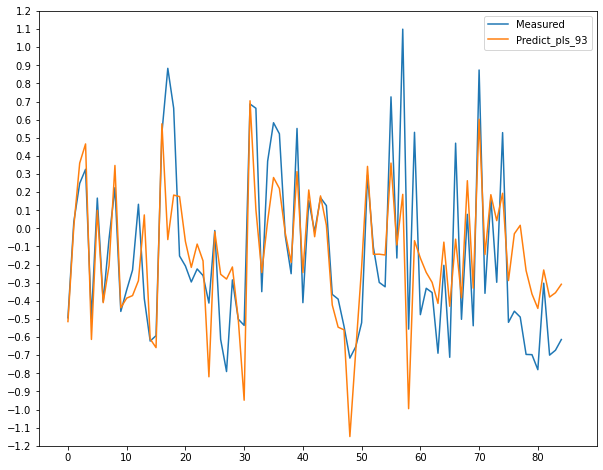

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(y_measured92,label='Measured')
plt.plot(y_predict92,label='Predict_pls_93')
plt.legend(loc='best')
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
l=[-5,90,-1.2,1.2]
plt.axis(l)
plt.xticks(list(range(0,90,10)))
plt.show()

No handles with labels found to put in legend.


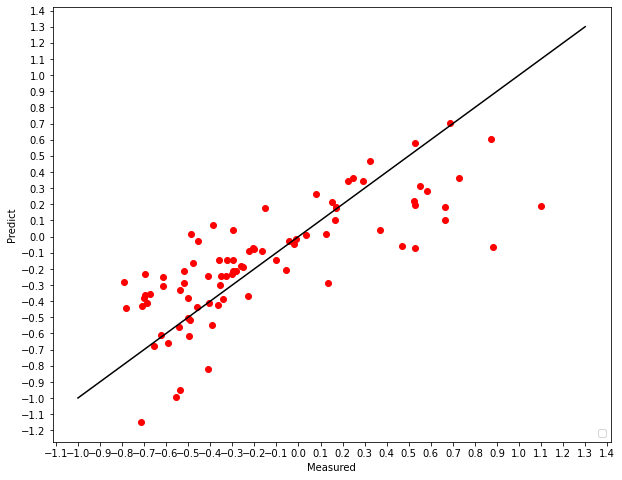

In [12]:
x_pre=np.linspace(-1,1.3,100)
y_pre=np.linspace(-1,1.3,100)
plt.figure(figsize=(10, 8))
plt.scatter(y_measured92,y_predict92,color='red')
plt.plot(x_pre,y_pre,color='black')
x_major_locator=MultipleLocator(0.1)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
l=[-1.2,1.2,-1.2,1.2]
plt.legend(loc='lower right')
plt.xlabel('Measured')
plt.ylabel('Predict')
plt.show()

In [9]:
feature_forward[0:93]

array(['struc156', 'x17', 'x43', 'GT', 'HK', 'KK', 'FN', 'HY', 'TA', 'RT',
       'TT', 'struc71', 'AA', 'DP', 'IY', 'YQ', 'VH', 'struc103',
       'struc16', 'x16', 'CG', 'CE', 'WS', 'struc68', 'WD', 'MQ', 'DC',
       'KC', 'struc45', 'CV', 'VW', 'EC', 'TC', 'struc91', 'YW', 'HW',
       'struc85', 'VQ', 'IM', 'struc135', 'EP', 'x84', 'QR', 'NW', 'CA',
       'WV', 'VC', 'DE', 'HA', 'KW', 'WP', 'PL', 'FF', 'MY', 'struc136',
       'struc84', 'RE', 'VS', 'struc27', 'MI', 'TM', 'struc54', 'PA',
       'struc67', 'HV', 'IL', 'struc35', 'DV', 'FE', 'AC', 'FQ', 'IV',
       'GK', 'x18', 'struc10', 'LI', 'YT', 'LH', 'CQ', 'x15', 'TH', 'MP',
       'EV', 'QC', 'ID', 'CH', 'EL', 'IF', 'KI', 'AH', 'MR', 'struc89',
       'DA'], dtype=object)

In [10]:
result_best=cross_output(x_647[feature_forward[0:93]],y,3)
result_best

array([0.76874162, 0.22048698, 0.48019546, 0.87666253, 0.89098752,
       0.60158324, 0.28315219, 0.6211155 , 0.827444  , 0.94313725])

In [11]:
structural=[s for s in feature_forward[0:93] if "struc" in s]
len(structural)

17

In [12]:
result_struc=cross_output(x_647[structural],y,3)
result_struc

array([ 0.18115839,  0.41489911,  0.9047098 ,  0.42376081,  0.43935565,
       -0.02579452,  0.44873257,  1.00852629,  0.26459496,  0.29901961])

In [13]:
physicochemistry=[s for s in feature_forward[0:93] if "x" in s]
len(physicochemistry)

6

In [14]:
result_phy=cross_output(x_647[physicochemistry],y,3)
result_phy

array([0.33945884, 0.37246388, 0.81175324, 0.58027631, 0.68394854,
       0.27395892, 0.37943963, 0.84665006, 0.59200072, 0.61323529])

In [15]:
feature93=list(feature_forward[0:93])
for i in structural+physicochemistry:
    feature93.remove(i)
result_seq=cross_output(x_647[feature93],y,3) 
result_seq

array([0.66076339, 0.26703763, 0.58214481, 0.81277076, 0.82054947,
       0.29577618, 0.3771135 , 0.83708661, 0.63765306, 0.59460852])

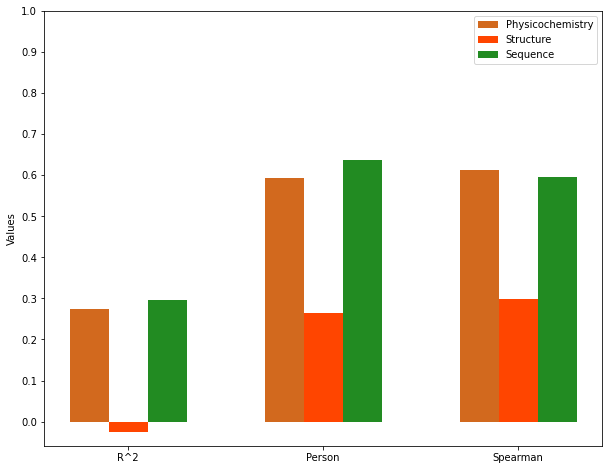

In [19]:
plt.figure(figsize=(10, 8))
labels = ['R^2','Person', 'Spearman']
x_bar = np.arange(len(labels))
width=0.2
plt.bar(x_bar-width,[0.27395892,0.59200072, 0.61323529],width,color='chocolate',label='Physicochemistry',)
plt.bar(x_bar,[-0.02579452,0.26459496,0.29901961],width,color='orangered',label='Structure')
plt.bar(x_bar+width,[0.29577618,0.63765306, 0.59460852],width,color='forestgreen',label='Sequence')
plt.ylabel('Values')
plt.xticks(x_bar,labels=labels)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend()

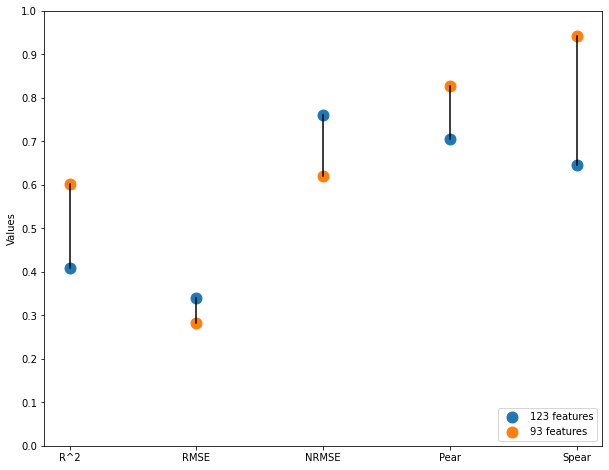

In [58]:
value123=[0.408352,0.339677,0.761814,0.705181,0.645098]
plt.figure(figsize=(10, 8))
label=['R^2','RMSE','NRMSE','Pear','Spear']
x=np.arange(len(label)) 
plt.scatter(x, value123,marker='o',s=120,label='123 features')
plt.scatter(x,result_best[5:],marker='o',s=120,label='93 features')
xx=[[0,0],[1,1],[2,2],[3,3],[4,4]]
yy=[[value123[0],result_best[5]],[value123[1],result_best[6]],[value123[2],result_best[7]],[value123[3],result_best[8]],[value123[4],result_best[9]]]
for i in x:
    plt.plot(xx[i],yy[i],color='black')
plt.ylabel('Values')
y_major_locator=MultipleLocator(0.1)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
l=[-0.2,4.2,0,1]
plt.axis(l)
plt.xticks(x,labels=label)
plt.legend(loc='lower right')

**<font size=5 color = red> mRMR method 和forward feature researching method 每50个feature 作为一个feature subset，用于component=3 的PLSR模型的训练时，Spearman coefficient对比图，</font>**

In [79]:
mid=list(pd.read_csv("/home/lynn/pls/code/data/mid-miq.csv")['mid'])
miq=list(pd.read_csv("/home/lynn/pls/code/data/mid-miq.csv")['miq'])
miq[634]='NA'
mid[620]='NA'
#mrmr-MID-feature
step50=list(range(50,647,50))+[647]
step50_1=list(range(0,647,50))
##按照mrmr_MID-feature的顺序每50个feature依次添加一个特征
out_mrmr_mid_feature_analysis=[]
for i,j in zip(step50_1,step50):
    x_mrmr_mid_analysis=x_647[mid[i:j]]
    out_mrmr_mid_feature_analysis.append(cross_output(x_mrmr_mid_analysis,y,3))
out_mrmr_mid_feature_analysis=pd.DataFrame(out_mrmr_mid_feature_analysis,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
out_mrmr_mid_feature_analysis

,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.641916,0.274051,0.598078,0.801065,0.748666,0.140950,0.406565,0.919519,0.559276,0.562745
1,0.630332,0.278705,0.607762,0.793823,0.791106,0.064100,0.424055,0.960156,0.479100,0.442157
2,0.771619,0.218729,0.477315,0.878325,0.835538,0.303829,0.364737,0.826228,0.695129,0.607843
3,0.425974,0.347264,0.757478,0.652393,0.684521,0.018974,0.440409,0.989441,0.391450,0.371569
4,0.583211,0.295970,0.645444,0.763594,0.775585,-0.106218,0.462954,1.042579,0.365569,0.347549
5,0.530274,0.314134,0.685137,0.728001,0.724152,0.083372,0.415649,0.940481,0.458853,0.419118
6,0.700241,0.250846,0.546687,0.836577,0.858526,0.090512,0.416553,0.944006,0.580166,0.581863
7,0.643551,0.273423,0.596600,0.802021,0.776697,0.017038,0.431497,0.977042,0.491846,0.414981
8,0.678261,0.260168,0.566854,0.823447,0.809841,0.115724,0.414580,0.935817,0.580495,0.506863
9,0.795295,0.206816,0.451413,0.891657,0.853121,0.288597,0.375832,0.842852,0.663376,0.590686


In [80]:

#根据上面forward 得到的feature order 每50个feature做一个pls
out_forward_result_feature_analysis=[]
for i,j in zip(step50_1,step50):
    x_forward_feature_analysis=x_647[feature_forward[i:j]]
    out_forward_result_feature_analysis.append(cross_output(x_forward_feature_analysis,y,3))
out_forward_result_feature_analysis=pd.DataFrame(out_forward_result_feature_analysis,columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
out_forward_result_feature_analysis


,train_R^2,train_RMSE,train_NRMSE,train_Pear,train_Spea,test_R^2,test_RMSE,test_NRMSE,test_Pear,test_Spea
0,0.659591,0.267290,0.582562,0.811785,0.840333,0.569356,0.292938,0.649197,0.810559,0.920098
1,0.407632,0.352906,0.769301,0.637880,0.676925,-0.232210,0.492378,1.105505,0.132474,0.136765
2,0.462088,0.335872,0.733002,0.679220,0.705524,-0.379766,0.518908,1.169275,0.135370,0.176961
3,0.475501,0.331668,0.723404,0.688559,0.696324,-0.113585,0.470943,1.052884,0.233613,0.298529
4,0.638868,0.275580,0.600736,0.799207,0.837317,0.304772,0.373468,0.828853,0.630706,0.602451
5,0.473846,0.332508,0.724519,0.687333,0.726312,-0.205064,0.489655,1.092020,0.233301,0.242647
6,0.570831,0.300290,0.654648,0.755216,0.784097,-0.111771,0.458053,1.040388,0.397560,0.399510
7,0.648363,0.271417,0.592549,0.805034,0.820170,0.112118,0.408444,0.929677,0.593352,0.524510
8,0.644285,0.273372,0.596128,0.802549,0.824927,0.006730,0.442791,0.994344,0.424208,0.428922
9,0.804546,0.201829,0.440606,0.896786,0.863580,0.300791,0.373610,0.831890,0.674748,0.605882


In [81]:
x_step=list(range(50,647,50))+[647]
mid_spea=out_mrmr_mid_feature_analysis.iloc[:,-1]
forward_spea=out_forward_result_feature_analysis.iloc[:,-1]


([<matplotlib.axis.XTick at 0x7fe140269280>,
 [Text(-1.0, 0, '1.0'),
  Text(-0.9, 0, '0.9'),
  Text(-0.8, 0, '0.8'),
  Text(-0.7, 0, '0.7'),
  Text(-0.6, 0, '0.6'),
  Text(-0.5, 0, '0.5'),
  Text(-0.4, 0, '0.4'),
  Text(-0.3, 0, '0.3'),
  Text(-0.2, 0, '0.2'),
  Text(-0.1, 0, '0.1'),
  Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

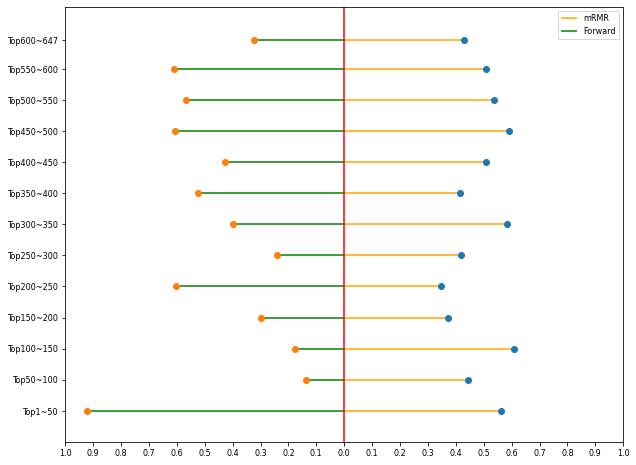

In [90]:
l=[-1,1,0,700]
plt.figure(figsize=(10, 8))
plt.axis(l)
plt.axvline(0,color='red')
plt.hlines(y=x_step,xmin=0,xmax=mid_spea,color='orange',label='mRMR')
plt.plot(mid_spea,x_step,'o')
plt.hlines(y=x_step,xmin=0,xmax=-forward_spea,color='green',label='Forward')
plt.plot(-forward_spea,x_step,'o')
plt.rcParams.update({'font.size': 8})
plt.legend(loc="upper right")
y_lable=['Top1~50','Top50~100','Top100~150','Top150~200','Top200~250','Top250~300','Top300~350','Top350~400','Top400~450','Top450~500','Top500~550','Top550~600','Top600~647']
plt.yticks(x_step,y_lable)
plt.xticks([-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],["1.0","0.9","0.8","0.7","0.6","0.5","0.4","0.3","0.2","0.1","0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"])


论文中的123个feature的结果分析

**<font size=5 color = red>为了验证PLSR模型对此项工作的可靠性，使用SVR，RFR 模型做对比。</font>**

In [17]:
def rf_model(x_train,y_train,x_test,y_test):
    ###寻优的SVM
    param_grid_rf={
                    'n_estimators':range(1,100),
                     'max_features':range(1,30),
                     'criterion':['mse'],
                    }
    rf_clf=GridSearchCV(RandomForestRegressor(),param_grid_rf,cv=10,n_jobs=-1).fit(x_train,y_train)
    rf=rf_clf.best_estimator_.fit(x_train,y_train)
    data_rf,predict_rf=predict_model(rf,x_train,y_train,x_test,y_test)
    return data_rf,predict_rf

def cross_rf(all_x,y):
    i=0
    test=[]
    predict=[]
    outdata=pd.DataFrame(columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for train_idx, test_idx in kf.split(all_x):
        X_train = preprocessing.scale(all_x.iloc[train_idx])
        X_test = preprocessing.scale(all_x.iloc[test_idx])
        y_train =y[train_idx]
        y_test = y[test_idx]
        data_all,predict_rf=rf_model(X_train,y_train,X_test,y_test)
        outdata.loc[i]=data_all
        test=test+list(y_test)
        predict=predict+list(predict_rf)
        i+=1
    out=np.array(outdata.mean(axis=0))
    return out,test,predict

In [30]:
out_rf,test_rf,predict_rf=cross_rf(all_x[feature_forward[0:647]],y)
out_rf

array([0.89630244, 0.14610332, 0.31831812, 0.95477005, 0.92631981,
       0.30585655, 0.36775168, 0.82841776, 0.64423322, 0.56323529])

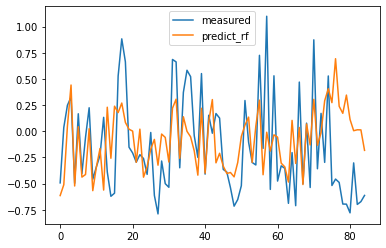

In [21]:
plt.plot(test_rf,label='measured')
plt.plot(predict_rf,label='predict_rf')
plt.legend(loc='best')

In [22]:
def svr_model(x_train,y_train,x_test,y_test):
    ###寻优的SVM
    par=[2**i for i in range(-6,7)]
    param_grid_sv={
                   'kernel':['rbf'],
                   'gamma':par,
                   'C':[0.01,0.1,0.5,1.0,5,10.0,15,20],
                   }
    
    svr_clf=GridSearchCV(SVR(),param_grid_sv,cv=5,n_jobs=-1).fit(x_train,y_train)
    svr=svr_clf.best_estimator_.fit(x_train,y_train)
    data_svr,test_predict=predict_model(svr,x_train,y_train,x_test,y_test)
    return data_svr,test_predict

def cross_svr(all_x,y):
    y_measured=[]
    y_predict=[]
    i=0
    outdata=pd.DataFrame(columns=('train_R^2','train_RMSE','train_NRMSE','train_Pear','train_Spea','test_R^2','test_RMSE','test_NRMSE','test_Pear','test_Spea'))
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for train_idx, test_idx in kf.split(all_x):
        X_train = preprocessing.scale(all_x.iloc[train_idx])
        X_test = preprocessing.scale(all_x.iloc[test_idx])
        y_train =y[train_idx]
        y_test = y[test_idx]
        data_all,test_predict=svr_model(X_train,y_train,X_test,y_test)
        outdata.loc[i]=data_all
        y_measured=y_measured+list(y_test)
        y_predict=y_predict+list(test_predict)
        i+=1
    out=np.array(outdata.mean(axis=0))
    return out,y_measured,y_predict

In [23]:
out_svr,test_svr,predict_svr=cross_svr(all_x[feature_forward[0:647]],y)
out_svr

array([ 0.32172062,  0.35071909,  0.75820816,  0.91212204,  0.96039098,
       -0.1017633 ,  0.46721161,  1.04869299,  0.71551356,  0.53921569])

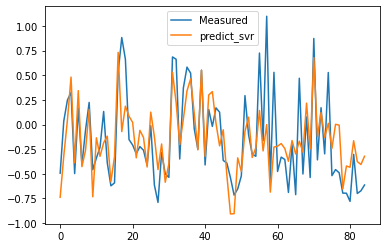

In [41]:
plt.plot(test_svr,label='Measured')
plt.plot(predict_svr,label='predict_svr')
plt.legend(loc='best')